transfer learning between a 1Dgamma and a 1Dgamma function with fixed parameters.

In [57]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc
from matplotlib.offsetbox import AnchoredText
import pandas as pd
from scipy import stats
import tensorflow as tf
from matplotlib import pyplot
from matplotlib import pyplot as plt
from qibo import gates, hamiltonians, models, set_backend, set_threads
import seaborn as sns

In [2]:
# functions

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham


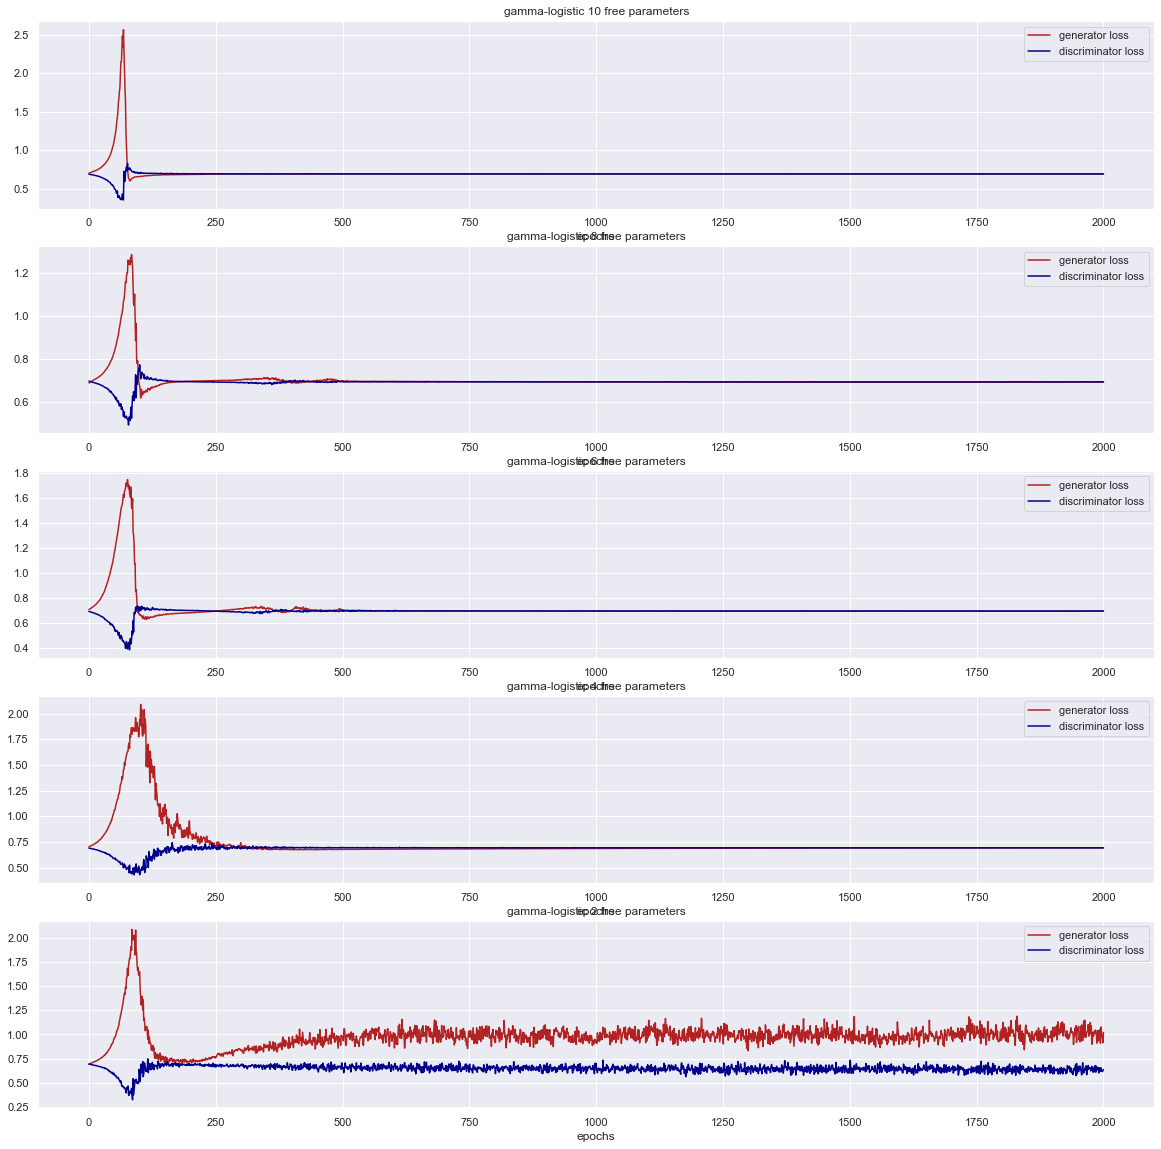

In [134]:
n_layers=128
fixed_params=range(0,10,2)
pyplot.figure(figsize=(20,20))
rows=5
cols=1
for i, val in enumerate(fixed_params):
    pyplot.subplot(rows,cols,i+1)
    d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ')
    #d_loss=d_loss[:10000]
    #g_loss=g_loss[:10000]
    #pyplot.figure(figsize=(20, 7), dpi=80)
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss,color="firebrick", label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss,color="darkblue", label='discriminator loss')
    pyplot.title(f'gamma-logistic {10-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    #pyplot.grid()

pyplot.show()


[-0.20641148 -0.58518205 -0.13690311  0.08302102  0.06579042 -0.3815577
 -0.01493959  0.13026852 -0.08842405 -0.63263864]
[ 0.09883213  0.08853395  0.12191209 -0.70836477 -0.09142093 -0.04415568
 -0.1108737  -0.57307555]
[-0.12345389 -0.55330716  0.06618886 -0.04089878  0.09752228 -0.72261014]
[ 0.25182193  1.08422955  0.02506255 -1.37457591]
[-0.0066514  -1.15466653]


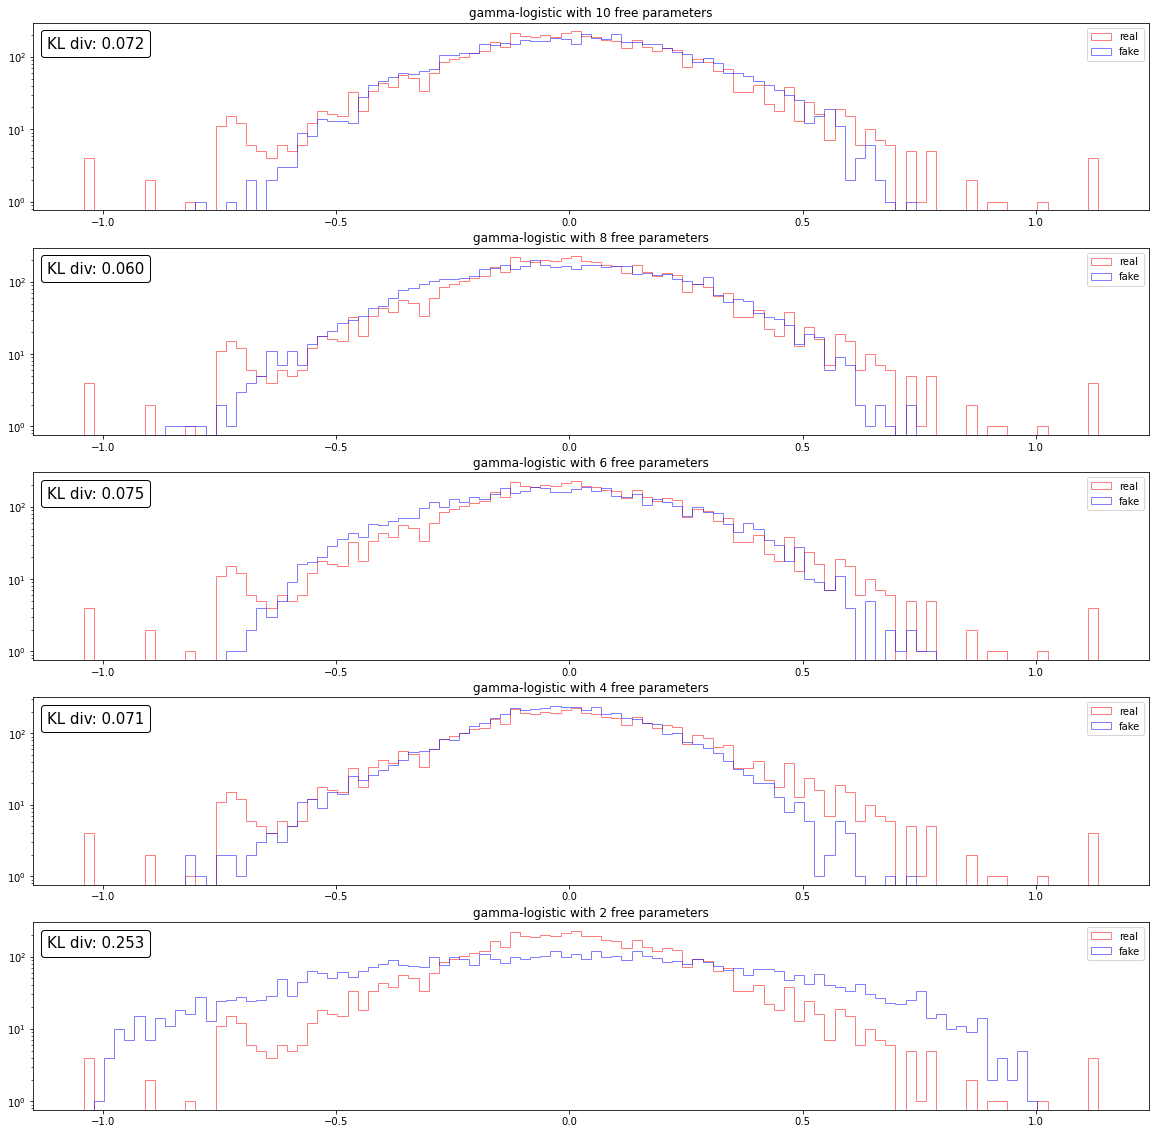

In [38]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0)) 
    
pyplot.figure(figsize=(20, 20))

s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)

distributions=[]
kl = []
kl.append("---")
distributions.append(x_real)
for i, val in enumerate(fixed_params):
    params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ', unpack='true')
    print(params)
    params = tf.Variable(params)
    #print(params)
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,val)
    distributions.append(x_fake)
    #x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
    #s=qc.generate_training_real_samples(samples)
    #x_real, y_real = qc.generate_real_samples(samples, s, 3000)

    nbins=100
    pyplot.subplot(rows,cols,i+1)
    #pyplot.figure(figsize=(14, 7))
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,histtype='step',label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],histtype='step',color='blue', label='fake', alpha=0.5)
    ax=pyplot.gca()
    kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
    at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.yscale('log')
    pyplot.title(f'gamma-logistic with {10-val} free parameters')
    pyplot.legend()
pyplot.show()

In [59]:
time=[]
time.append("---")
for val in fixed_params:
    t=np.loadtxt(f"time_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}")
    
    time.append(int(t))


In [84]:
from IPython.display import display
# fake 10 = fake distribution with 10 free parameters
moments = pd.DataFrame(
    {
        "distribution":["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment":[stats.moment(i,moment=4)[0] for i in distributions],
        "kl": [*kl],
        "time (s)":[*time]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment,kl,time (s)
0,real,0.003479,0.059190,-0.000108,0.014578,---,---
1,fake 10,0.013156,0.052170,0.000070,0.007532,0.072033,8202
2,fake 8,-0.014893,0.057687,-0.000659,0.009245,0.060123,7354
3,fake 6,-0.022136,0.057830,0.000476,0.008963,0.075443,5034
4,fake 4,-0.016162,0.039603,-0.001273,0.005481,0.070982,4524
5,fake 2,-0.016804,0.153512,-0.000767,0.058830,0.252559,3293


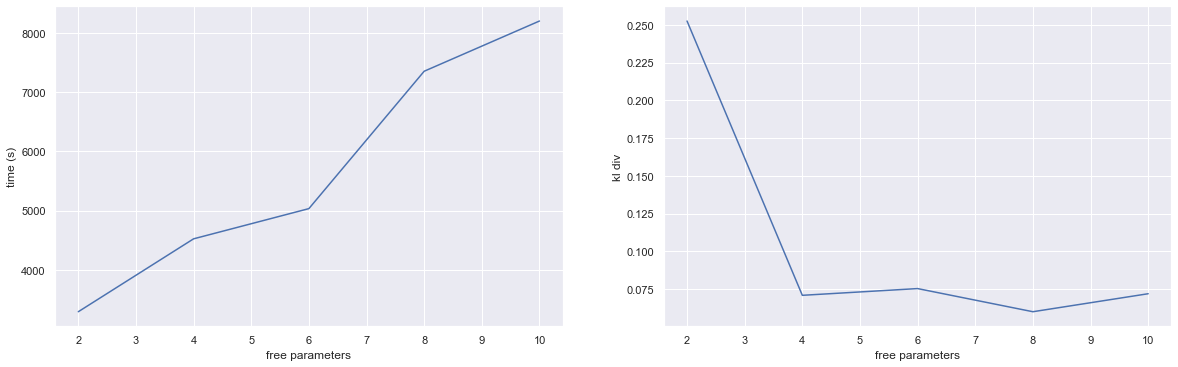

In [88]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
free_params=range(10,0,-2)
plt.plot(free_params,moments["time (s)"][1:])
plt.xlabel("free parameters")
plt.ylabel("time (s)")
plt.grid(True)

plt.subplot(3,2,2)
free_params=range(10,0,-2)
plt.plot(free_params,moments["kl"][1:])
plt.xlabel("free parameters")
plt.ylabel("kl div")
plt.grid(True)

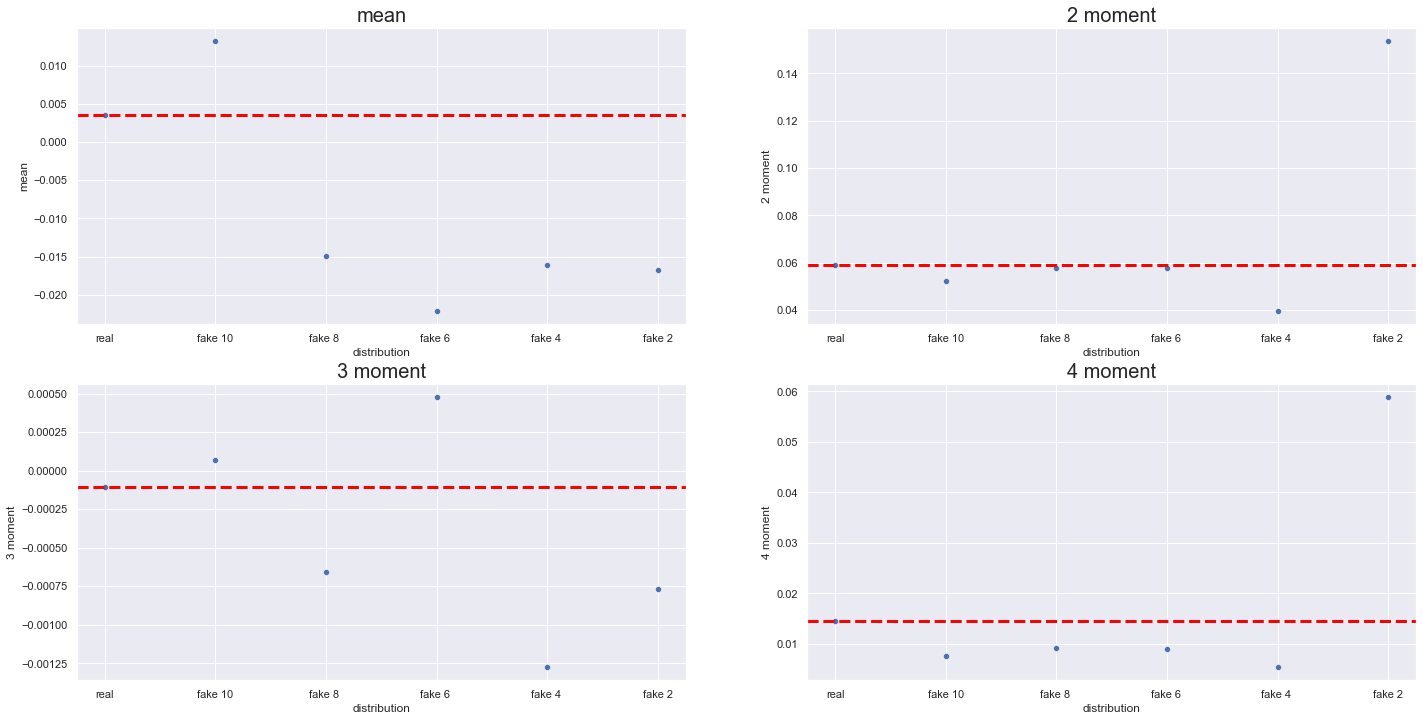

In [132]:

fig, ax = plt.subplots(2,2, figsize = (24, 12))
sns.scatterplot(x="distribution", y="mean", ax=ax[0][0], data = moments)
#ax[0][0].grid(Tu)
ax[0][0].axhline(y=moments["mean"][0],ls='--', linewidth=3, color='red') 
ax[0][0].set_title("mean",fontsize = 20)

sns.scatterplot(x="distribution", y="2 moment",ax=ax[0][1], data = moments)
ax[0][1].axhline(y=moments["2 moment"][0],ls='--', linewidth=3, color='red') 
ax[0][1].set_title("2 moment", fontsize = 20)

sns.scatterplot(x="distribution", y="3 moment",ax=ax[1][0], data = moments)
ax[1][0].axhline(y=moments["3 moment"][0],ls='--', linewidth=3, color='red') 
ax[1][0].set_title("3 moment", fontsize = 20);

sns.scatterplot(x="distribution", y="4 moment",ax=ax[1][1], data = moments)
ax[1][1].axhline(y=moments["4 moment"][0],ls='--', linewidth=3, color='red') 
ax[1][1].set_title("4 moment", fontsize = 20);

In [36]:
print(moments.to_latex(index=False))  

\begin{tabular}{lrrrrll}
\toprule
           distribution &      mean &  2 moment  &  3 moment &  4 moment  &       kl  & time ( s ) \\
\midrule
                   real &  0.005026 &   0.056447 & -0.001282 &   0.014685 &       --- &        --- \\
fake 10 free parameters &  0.012007 &   0.052235 &  0.000280 &   0.007426 &   0.07706 &       8202 \\
 fake 8 free parameters & -0.018812 &   0.058205 & -0.000511 &   0.009428 &  0.074142 &       7354 \\
 fake 6 free parameters & -0.022067 &   0.057637 &  0.000259 &   0.009017 &  0.078144 &       5034 \\
 fake 4 free parameters & -0.013617 &   0.036802 & -0.000968 &   0.004824 &  0.086366 &       4524 \\
 fake 2 free parameters & -0.022859 &   0.154026 &  0.001838 &   0.056617 &  0.292848 &       3293 \\
\bottomrule
\end{tabular}



/var/folders/s2/82sd15fd5zx5zvjy5hnfkg1m0000gn/T/ipykernel_10875/1208205541.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(moments.to_latex(index=False))
